In [514]:
import json
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import datetime


In [515]:
# Connect to database
with open("config.json", "r") as f:
    config = json.load(f)

endpoint = config["endpoint"]
username = config["username"]
password = config["password"]
database_name = config["database_name"]


connection = pymysql.connect(
    host=endpoint, user=username, password=password, db=database_name)
cursor = connection.cursor()


In [516]:
# Runs queries to retrieve the data of a given table name. Converts it into a pandas DataFrame
def get_table(table_name, query):
    with connection.cursor() as cursor:
        # Get table data
        cursor.execute(query)
        data = cursor.fetchall()

        # Get column names
        cursor.execute(f"SHOW COLUMNS "
                       f"FROM {table_name}")
        col_data = cursor.fetchall()
        cols = [col[0] for col in col_data]

        # Save to dataframe
        df = pd.DataFrame(data, columns=cols)
    return df


In [517]:
# Removes duplicate rows from the dataframe
def remove_duplicates(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)


In [518]:
# Removes data that is out of range of the gym's hours. Removes data that was mistakenly added when the gym was closed
def remove_hours(df):
    df = df[
        (((df.Weekday_Word == 'Monday') | (df.Weekday_Word == 'Tuesday') | (df.Weekday_Word == 'Wednesday') | (df.Weekday_Word == 'Thursday'))  # Monday-Thursday
         & (df.Hour >= 6) & (df.Hour < 24)) |  # Monday-Thursday
        ((df.Weekday_Word == 'Friday') & (df.Hour >= 6) & (df.Hour < 22)) |  # Friday
        ((df.Weekday_Word == 'Saturday') & (df.Hour >= 8) & (df.Hour < 22)) |  # Saturday
        ((df.Weekday_Word == 'Sunday') & (df.Hour >= 8) & (df.Hour < 24))  # Sunday
    ]


In [519]:
# Calls all functions related to cleaning the data
def clean_data(df):
    remove_duplicates(df)
    remove_hours(df)


In [520]:
# Adds dates to the dataframe (I forgot to add them to the database when I made it)
def add_dates(df):
    day = datetime.datetime(year=2022, month=10, day=30)
    week_day = 'Sunday'
    days = []

    for index, row in df.iterrows():
        if week_day != row.Weekday_Word:
            week_day = row.Weekday_Word
            day += datetime.timedelta(days=1)

        days.append(day)
    df["Date"] = days


In [521]:
# Returns a fully processed dataframe
def get_df(table_name, query):
    df = get_table(table_name, query)
    clean_data(df)
    add_dates(df)

    return df


In [522]:
# Gets the left and right indecies (alternating in a 1-D list) of a dataframe for a certain day of the week
def get_index_list(weekday, df):
    index_list = []
    prev = None

    for index, row in df.iterrows():
        if row.Weekday_Word == weekday and row.Weekday_Word != prev:
            index_list.append(index)
        if row.Weekday_Word != prev and prev == weekday:
            index_list.append(index - 1)

        prev = row.Weekday_Word

    return index_list


In [523]:
# Uses the index_list to cerate a dataframe containing only rows of a certain day
def get_day_df(weekday, df):
    index_list = get_index_list(weekday, df)

    day_df = df.loc[index_list[0]:index_list[1]]
    for i in range(3, len(index_list), 2):
        l, r = index_list[i-1], index_list[i]
        day_df = pd.concat([day_df, df.loc[l:r]])

    return day_df


In [524]:
# Creates a dataframe that calculates the average population of each hour
def get_average_df(df, weekday=None, entire_week=False):
    if weekday is not None:
        day_df = get_day_df(weekday, df)
    elif entire_week:
        day_df = df
    else:
        return -1

    averages = None
    for i in range(25):
        hour_df = day_df.groupby(day_df.Hour == i).mean(numeric_only=True)

        if True in hour_df.index:
            pop = hour_df.loc[True].Population

            average = pd.DataFrame.from_dict(
                {'Hour': [i], 'Population': [pop]})

            try:
                averages = pd.concat([averages, average])

            except:
                averages = average

    return averages


In [525]:
# Plots 8 figures (Overall and 1 for each day of the week) of a given table name
def plot_table(table_name, query):
    df = get_df(table_name, query)

    m, n = 4, 2
    fig, axes = plt.subplots(m, n)

    days = ['Overall', 'Monday', 'Tuesday', 'Wednesday',
            'Thursday', 'Friday', 'Saturday', 'Sunday']

    for i in range(m):
        for j in range(n):
            if (n * i + j) >= len(days):
                break

            ax = axes[i][j]
            weekday = days[n * i + j]

            if weekday == 'Overall':
                averages = get_average_df(df, entire_week=True)
                color = 'red'
            else:
                averages = get_average_df(df, weekday)
                color = 'black'
            ax.plot(averages.Hour, averages.Population, color=color)

            # Plot
            ax.set_title(weekday)
            ax.set_xlabel('Hour')

            if weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
                ax.set_xbound(6, 24)
            elif weekday == 'Friday':
                ax.set_xbound(6, 22)
            elif weekday == 'Saturday':
                ax.set_xbound(8, 22)
            else:
                ax.set_xbound(8, 24)

            ax.set_ylabel('Population')

    fig.suptitle(table_name, fontsize=20)
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    plt.show()

    return


In [526]:
table_name = "Lvl3"


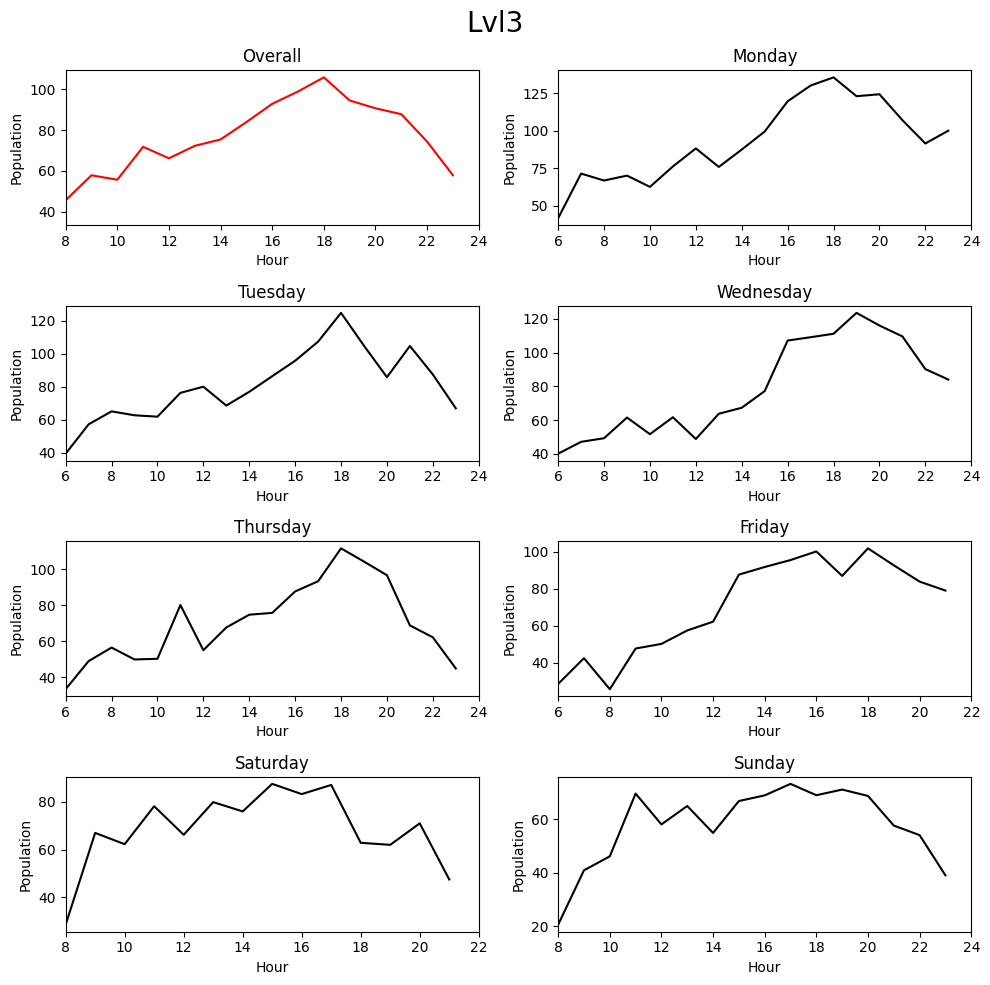

In [527]:
query = f"SELECT * FROM {table_name}"

plot_table(table_name, query)


In [528]:
def get_n_days(end_days, start_days=0):
    query = (f"SELECT * FROM {table_name}")
    df = get_df(table_name, query)

    end = df.shape[0]
    days = 0
    prev = -1

    while days < start_days+1:
        end -= 1
        curr = df.iloc[end].Weekday

        if prev != curr:
            days += 1
        prev = curr

    start = end + 1
    days = 0
    while days < end_days:
        start -= 1
        next = df.iloc[start-1].Weekday

        if curr != next:
            days += 1
        curr = next

    if end < 0 or start < 0:
        raise Exception

    return df.iloc[start:end+1]

In [529]:
today = datetime.datetime.now()
curr_year = today.year
curr_month = today.month
curr_day = today.day

df_list = []

# Current week
curr_week_df = get_n_days(7)
df_list.append(curr_week_df)

# Last week
last_week_df = get_n_days(7, 7)
df_list.append(last_week_df)

# Current month
curr_month_query = (
    f"SELECT * FROM {table_name} "
    f"WHERE Year={curr_year} AND Month={curr_month}"
)
curr_month_df = get_df(table_name, curr_month_query)
df_list.append(curr_month_df)

# Last month
if curr_month == 1:
    last_month = 12
    last_month_year = curr_year - 1
else:
    last_month = curr_month - 1
    last_month_year = curr_year

last_month_query = (
    f"SELECT * FROM {table_name} "
    f"WHERE Year={last_month_year} AND Month={last_month}"
)
last_month_df = get_df(table_name, last_month_query)
df_list.append(last_month_df)

# 2022
last_year = curr_year - 1

last_year_query = (
    f"SELECT * FROM {table_name} "
    f"WHERE Year={last_year}"
)
last_year_df = get_df(table_name, last_year_query)
df_list.append(last_year_df)

# Display dataframes
# for df in df_list:
#     display(df)

# describe() dataframes
for i in range(len(df_list)):
    df_list[i] = df_list[i].describe()[["Population", "Percent_Capacity"]]

In [532]:
curr_week_mean = round(df_list[0].Population.loc['mean'], 2)
last_week_mean = round(df_list[1].Population.loc['mean'], 2)
curr_month_mean = round(df_list[2].Population.loc['mean'], 2)
last_month_mean = round(df_list[3].Population.loc['mean'], 2)
last_year_mean = round(df_list[4].Population.loc['mean'], 2)

means = [
    ("Last year", last_year_mean), ("Last month", last_month_mean),
    ("Current month", curr_month_mean), ("Last week", last_week_mean),
    ("Current week", curr_week_mean)
    

    
]

# Print all means
for key, value in means:
    print(f"{key}: {value}")
print()

# Print % changes in means 
combinations = []

for i in range(len(means)):
    for j in range(i+1, len(means)):
        combinations.append((means[i], means[j]))

for comb1, comb2 in combinations:
    change = round(comb2[1] / comb1[1] * 100, 2)

    if change > 100:
        result = f"increase of {change}%"
    elif change < 100:
        result = f"decrease of {change}%"
    else:
        result = "no change"

    print(f"{comb1[0]} -> {comb2[0]} ({comb1[1]} -> {comb2[1]}): {result}")

Last year: 71.12
Last month: 67.54
Current month: 93.92
Last week: 93.22
Current week: 93.89

Last year -> Last month (71.12 -> 67.54): decrease of 94.97%
Last year -> Current month (71.12 -> 93.92): increase of 132.06%
Last year -> Last week (71.12 -> 93.22): increase of 131.07%
Last year -> Current week (71.12 -> 93.89): increase of 132.02%
Last month -> Current month (67.54 -> 93.92): increase of 139.06%
Last month -> Last week (67.54 -> 93.22): increase of 138.02%
Last month -> Current week (67.54 -> 93.89): increase of 139.01%
Current month -> Last week (93.92 -> 93.22): decrease of 99.25%
Current month -> Current week (93.92 -> 93.89): decrease of 99.97%
Last week -> Current week (93.22 -> 93.89): increase of 100.72%


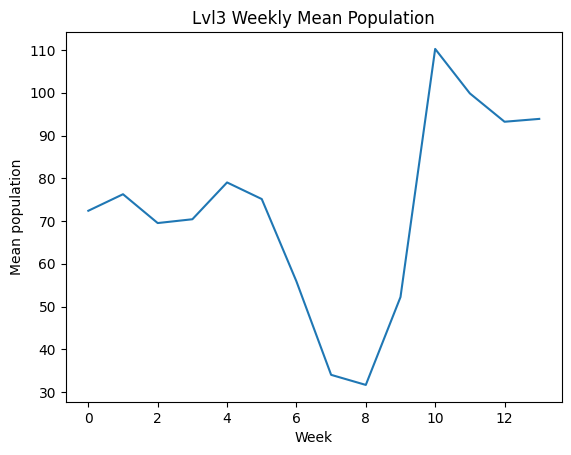

In [531]:
# Get weekly mean
done = False
start_day = 0
data = []

while not done:
    try: 
        df = get_n_days(7, start_day)
        mean = df.Population.mean()
        data.append(mean)

        start_day += 7
    except:
        done = True
data.reverse()

# Plot
y_data = []
for i in range(len(data)):
    y_data.append(i)

fig, ax = plt.subplots()

ax.plot(y_data, data)
ax.set_title(f"{table_name} Weekly Mean Population")
ax.set_ylabel("Mean population")
ax.set_xlabel("Week")

plt.show()